In [501]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import pickle
from itertools import chain
import operator

%matplotlib inline

In [502]:
# Read pickled file on top 200 images 
with open('top200.pkl', 'rb') as f:
    top200images = pickle.load(f)

In [503]:
# Read pickled cluster centers
with open('mbk_means_cluster_centers.pkl', 'rb') as w1:
    mbk_means_cluster_centers = pickle.load(w1)

In [504]:
mbk_means_cluster_centers.shape

(2000, 128)

In [506]:
# Read image dataframe
image_df1 = pd.read_pickle('image_df.pickle')

In [507]:
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Unable to open '%s'. Are you sure it's a valid image path?")
    return img

In [508]:
# Upload test image and calculate keypoints and descriptors
from PIL import Image
img_test_path = "image1b_chanel.jpg"
img_test = read_image(img_test_path)
gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp_test, desc_test = sift.detectAndCompute(gray_test, None)

In [509]:
class RootSIFT(object):
    # From http://www.pyimagesearch.com/2015/04/13/implementing-rootsift-in-python-and-opencv/
    
    def __init__(self):
        # initialize the SIFT feature extractor
        self.extractor = cv2.DescriptorExtractor_create("SIFT")

    def compute(self, image, kps, eps=1e-7):
        # compute SIFT descriptors
        (kps, descs) = self.extractor.compute(image, kps)

        # if there are no keypoints or descriptors, return an empty tuple
        if len(kps) == 0:
            return ([], None)

        # apply the Hellinger kernel by first L1-normalizing and taking the
        # square-root
        descs /= (descs.sum(axis=1, keepdims=True) + eps)
        descs = np.sqrt(descs)
        #descs /= (np.linalg.norm(descs, axis=1, ord=2) + eps)

        # return a tuple of the keypoints and descriptors
        return (kps, descs)

In [510]:
"""
Function to match a feature in one image to a feature in 
another image is to use the ratio of the distance to the two closest matching features. 
This ensures that only features that are distinct enough compared to the other features in the image are used. 
As a consequence, the number of false matches is lowered. 
"""

from array import array
from scipy import linalg
def match(desc1,desc2):
    """ For each descriptor in the first image,
    select its match in the second image.
    input: desc1 (descriptors for the first image),
    desc2 (same for second image). """
    desc1 = np.array([d/linalg.norm(d) for d in desc1])
    desc2 = np.array([d/linalg.norm(d) for d in desc2])
    dist_ratio = 0.6  
    desc1_size = desc1.shape
    matchscores = np.zeros((desc1_size[0],1),'int')
    desc2t = desc2.T # precompute matrix transpose  
    for i in range(desc1_size[0]):
        dotprods = np.dot(desc1[i,:],desc2t) # vector of dot products
        dotprods = 0.9999*dotprods
        # inverse cosine and sort, return index for features in second image
        indx = np.argsort(np.arccos(dotprods))
        #print(indx)
    # check if nearest neighbor has angle less than dist_ratio times 2nd
        if np.arccos(dotprods)[indx[0]] < dist_ratio * np.arccos(dotprods)[indx[1]]:
            #print (np.arccos(dotprods)[indx[0]], np.arccos(dotprods)[indx[1]])
            matchscores[i] = int(indx[0])
            print (matchscores[i])
    return matchscores

In [511]:
"""
To further increase the robustness of the matches, we can reverse the procedure and match 
the other way (from the features in the second image to features in the first) and only keep 
the correspondences that satisfy the matching criteria both ways (same as what we did for the Harris points). 
The function match_twosided() does just this.
"""

def match_twosided(desc1,desc2):
    """ Two-sided symmetric version of match(). """
    matches_12 = match(desc1,desc2)
    matches_21 = match(desc2,desc1)
    ndx_12 = np.nonzero(matches_12)[0]
# remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0
    return matches_12

In [ ]:
# Find matches in top 200 images
match_list = {}
for image in top200images:
    img2_path = image_df1.iloc[image[0]]['image_path']
    img_ftr = read_image(img2_path) 
    gray2 = cv2.cvtColor(img_ftr, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp2, desc2 = sift.detectAndCompute(gray2, None)
    test = match_twosided(desc1, desc2)
    match_list[elt[0]] = linalg.norm(test)

In [514]:
# Get sorted index
def return_index(match_list):
    sorted_match = sorted(match_list.items(), key=operator.itemgetter(1))
    return sorted_match

In [515]:
best_matches = return_index(match_list)

In [336]:
def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Unable to open '%s'. Are you sure it's a valid image path?")
    return img

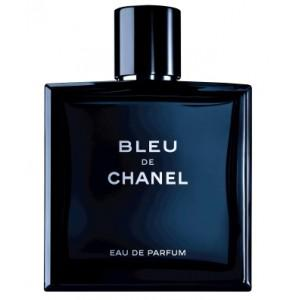

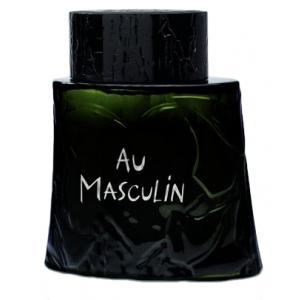

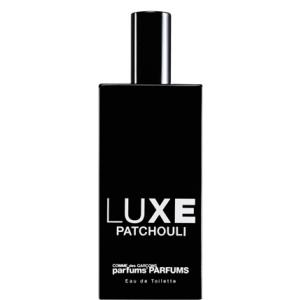

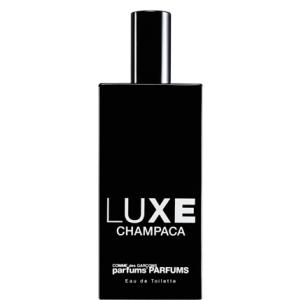

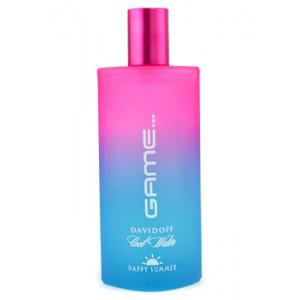

In [522]:
from IPython.display import Image
from IPython.display import display
image11 = Image(filename=image_df1.iloc[best_matches[-1]]['image_path'])
image2 = Image(filename=image_df1.iloc[best_matches[-2]]['image_path']) 
image3 = Image(filename=image_df1.iloc[best_matches[-3]]['image_path']) 
image4 = Image(filename=image_df1.iloc[best_matches[-4]]['image_path']) 
image5 = Image(filename=image_df1.iloc[best_matches[-5]]['image_path']) 
display(image1, image2, image3, image4, image5)